# Telco Customer Churn & GPT Feedback – Notebook Series

We focus on customers who left written feedback, and combine structured features with unstructured text using TF-IDF.  
The goal is to train a "teacher model" with maximum predictive power, which will later help improve the fallback system.

---

### Project Structure:

1. **Exploring Customer Churn & GPT-generated Feedback**  
   → Data exploration & text insights

2. **Feedback Noise Simulation & Fallback Testing**  
   → Simulate real-world feedback imperfections

3. **Fallback Model – Logistic vs XGB vs RF vs NN**  
   → Structured-only models, compared & evaluated

4. **Model with Feedback – Logistic vs XGB vs NN**  
   → Hybrid modeling using structured + textual data

5. **Prediction using Synthetic Feedback Knowledge**  
   → Transfer feedback model knowledge to fallback model


### Table of Contents
1. [Load & Preview the Data](#load)
2. [Basic exploration](#Basicexploration)
3. [Chrun statistics](#Churnstatistics)
4. [Sample Customer Feedback](#SampleCustomerFeedback)
5. [Chrun Analysis by Features](#ChrunAnalysisbyFeatures)
6. [Feedback exploration](#Feedbackexploration)
7. [Simple sentiment anaysis](#Simplesentimentanaysis)
8. [Summary](#Summary)
9. [Notebook Series Overview](#NotebookSeriesOverview)
---


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

plt.style.use('ggplot')
sns.set_theme()

## 1. Load & Preview the Data
<a id='load'></a>

In [2]:
# Load data
df = pd.read_csv('/kaggle/input/telco-customer-churn-realistic-customer-feedback/telco_churn_with_all_feedback.csv')

## 2. Basic exploration
<a id='Basicexploration'></a>

In [3]:
df.shape, df.columns

((7043, 23),
 Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
        'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
        'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
        'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
        'PromptInput', 'CustomerFeedback'],
       dtype='object'))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,PromptInput,CustomerFeedback
84,0318-ZOPWS,Female,0,Yes,No,49,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),20.15,973.35,No,Write a realistic customer feedback based on t...,I have been a customer with this company for a...
6442,9278-VZKCD,Female,1,Yes,No,52,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Month-to-month,Yes,Electronic check,109.10,5647.95,No,Write a realistic customer feedback based on t...,I have been a customer with this company for o...
4080,2091-GPPIQ,Female,0,Yes,Yes,72,Yes,Yes,DSL,No,...,Yes,Yes,Two year,Yes,Electronic check,78.95,5730.15,No,Write a realistic customer feedback based on t...,I have been a loyal customer with this DSL pro...
249,0959-WHOKV,Male,0,No,No,42,Yes,Yes,Fiber optic,Yes,...,No,Yes,One year,Yes,Electronic check,99.00,4298.45,No,Write a realistic customer feedback based on t...,"""I have been a customer for 42 months now and ..."
5697,0581-BXBUB,Female,1,No,No,4,Yes,No,Fiber optic,No,...,No,No,Month-to-month,No,Electronic check,72.75,317.75,No,Write a realistic customer feedback based on t...,I have been a customer with this fiber optic i...


In [6]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
PromptInput         0
CustomerFeedback    0
dtype: int64

## 3. Churn statistics
<a id='Churnstatistics'></a>

In [7]:
# Percentage of customers with feedback
has_feedback = df['CustomerFeedback'].notna()
df['HasFeedback'] = has_feedback
has_feedback.mean()

1.0

In [8]:
df['feedback_length'] = df['CustomerFeedback'].str.len()
df['feedback_length'].describe()

count    7043.000000
mean      460.571205
std        68.197917
min       277.000000
25%       414.000000
50%       454.000000
75%       499.000000
max       840.000000
Name: feedback_length, dtype: float64

In [9]:
df['Churn'].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

## 4. Sample Customer Feedback
<a id='SampleCustomerFeedback'></a>

In [10]:
pd.set_option('display.max_colwidth', None)
# Sample loyal customers with feedback
churned = df[(df['Churn'] == 'Yes')]
churned[['customerID', 'CustomerFeedback']].sample(3, random_state=1)

,customerID,CustomerFeedback
4572,6481-OGDOO,"""I've been a loyal customer for over 5 years now, but unfortunately I've decided to churn. The $90.6 monthly charges for fiber optic internet were starting to become too costly for me. I appreciated the convenience of automatic credit card payments, but ultimately I had to make a change due to budget constraints. Overall, the service was reliable and the speeds were great, but I needed to find a more affordable option."""
5971,8749-JMNKX,"I have been a customer with this company for over four years and have been relatively satisfied with the service provided. However, I recently decided to switch to a different provider due to better pricing options. The monthly charges were a bit high for me at $93.8, especially considering I was on a month-to-month contract. The fiber optic internet service was reliable and fast, but I felt that I could find a better deal elsewhere. The automatic bank transfer payment method was convenient and hassle-free. Overall, I had a positive experience with the company but ultimately chose to leave due to pricing considerations."
5927,4585-HETAI,"I recently switched to this internet provider four months ago and unfortunately, I have already decided to churn. While the fiber optic internet service was fast and reliable, I found the monthly charges to be on the higher side at $73.75. Additionally, the payment method of electronic check was not very convenient for me. Overall, I was satisfied with the service quality but ultimately decided to switch to a different provider for better pricing and payment options."


In [11]:
# Sample loyal customers with feedback
churned = df[(df['Churn'] == 'No')]
churned[['customerID', 'CustomerFeedback']].sample(3, random_state=1)

,customerID,CustomerFeedback
6673,4439-YRNVD,"I have been a customer with this DSL provider for 10 months now on a month-to-month contract with a monthly charge of $36.25. I have found the service to be reliable and the internet speed to be sufficient for my needs. I appreciate the convenience of paying with electronic check. Overall, I am satisfied with the service and have had no issues that would make me consider switching providers."
1785,0506-YLVKJ,"I have been a customer with this company for 46 months now and I have been very satisfied with their service. I appreciate the affordable monthly charges of $20.2 and the convenience of being able to pay through mailed check. Even though I do not use their internet service, I have had no issues with the other services provided. Overall, I have had a positive experience and would recommend this company to others."
1539,4632-PAOYU,"I have been a customer with this company for almost two years now and I have been satisfied with the service. Even though I do not have internet service with them, I appreciate the affordable monthly charges of $19.95. I prefer to pay by mailed check and have had no issues with the payment process. Overall, I have had a positive experience with this company and have no plans to churn in the near future."


## 5. Churn Analysis by Features
<a id='ChurnAnalysisbyFeatures'></a>

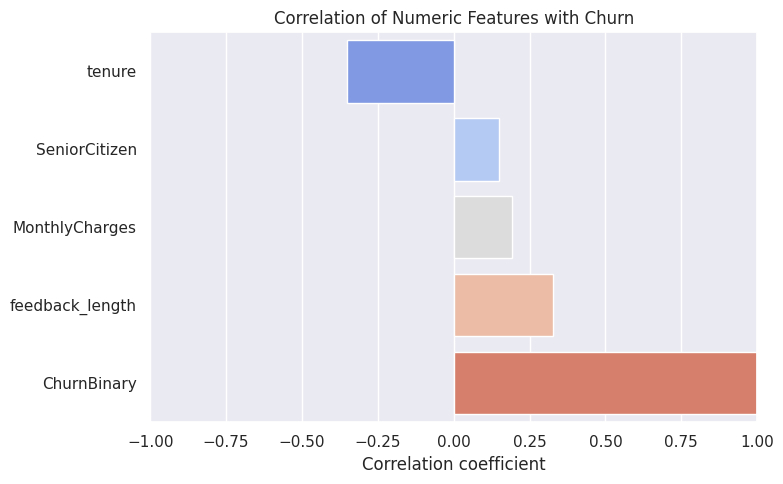

In [12]:
# Binary mapping
df['ChurnBinary'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Numeric features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
correlations = df[numeric_cols].corrwith(df['ChurnBinary']).sort_values()

# Barplot
plt.figure(figsize=(8, 5))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title("Correlation of Numeric Features with Churn")
plt.xlabel("Correlation coefficient")
plt.xlim(-1, 1)
plt.tight_layout()
plt.show()


>The plot shows the Pearson correlation between numerical features and churn probability (ChurnBinary).

>Positive correlations (in red): Features like feedback_length and MonthlyCharges are positively associated with churn — customers with higher values here are more likely to leave.

>Negative correlations (in blue): Features like tenure are negatively correlated with churn — indicating longer-tenured or more satisfied customers tend to stay.

>While the correlation values are moderate, they support intuitive hypotheses and can guide feature selection in churn modeling.

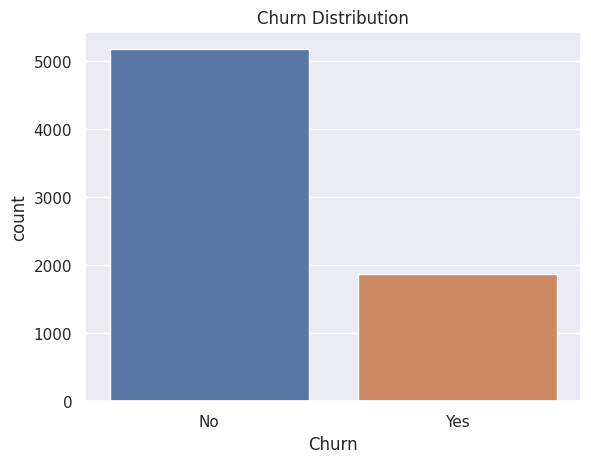

In [13]:
sns.countplot(data=df, x='Churn')
plt.title('Churn Distribution')
plt.show()

>This plot shows the class distribution for the Churn variable.<br>
Approximately 26.5% of customers in the dataset have churned (Yes)<br>
The remaining 73.5% stayed with the company (No)<br>
This class imbalance is common in churn problems and should be addressed during modeling (e.g. with stratified sampling, rebalancing techniques, or adjusted thresholds).

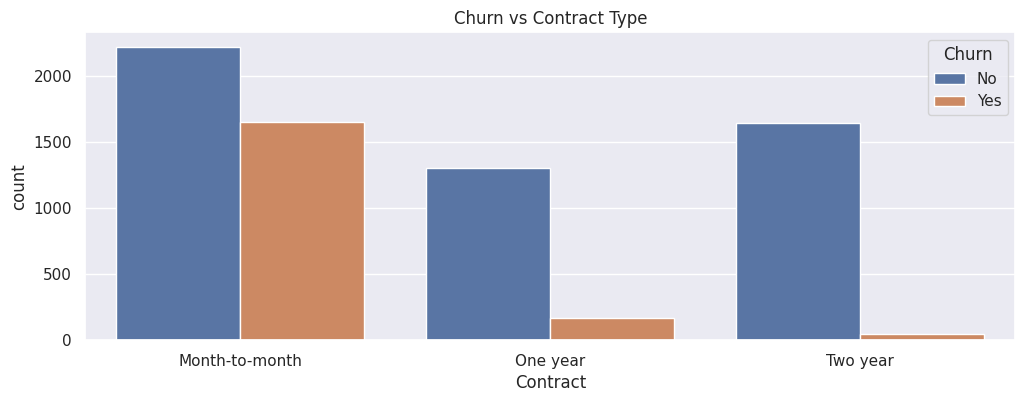

In [14]:
# churn vs contract / internet
plt.figure(figsize=(12, 4))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn vs Contract Type')
plt.show()


>Customers on Month-to-month contracts are far more likely to churn than those with 1- or 2-year agreements. <br>
Long-term contracts (1 or 2 years) show a clear retention effect — churn is minimal in these segments.<br>
This highlights the importance of commitment-based plans in customer retention strategies.<br>

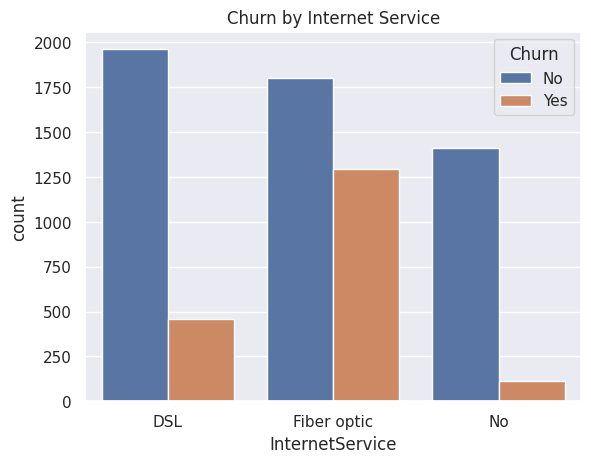

In [15]:
# Internet Service
sns.countplot(data=df, x='InternetService', hue='Churn')
plt.title('Churn by Internet Service')
plt.show()

>Fiber optic customers show the highest churn rates, despite being on a modern service.<br>
Customers without internet service rarely churn — possibly indicating lower expectations or simpler plans.<br>
The churn rate among DSL customers is moderate, suggesting mixed satisfaction or value perception.<br>

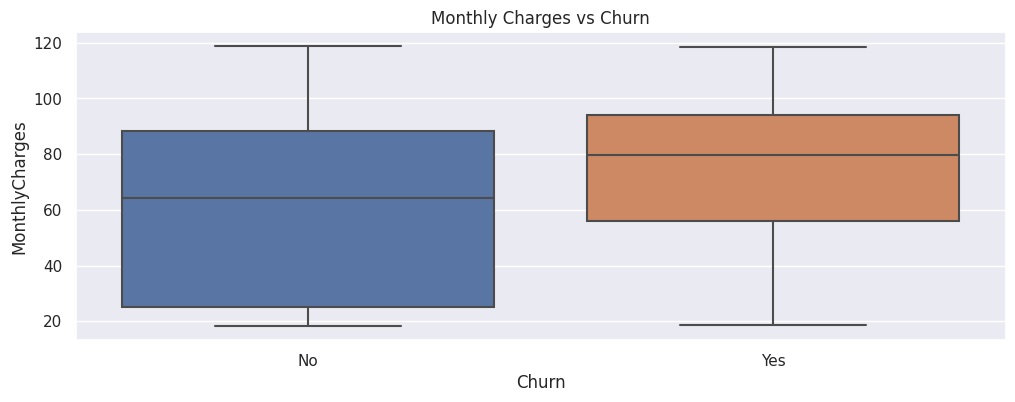

In [16]:
plt.figure(figsize=(12, 4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs Churn')
plt.show()

>Customers who churn tend to have slightly higher monthly charges on average. <br>
The distribution is wider among churned users, suggesting that pricing may be a key factor in customer dissatisfaction.  <br>
This supports the hypothesis that high monthly cost can be a churn driver, especially for cost-sensitive segments.  <br>

## 6. Feedback exploration
<a id='Feedbackexploration'></a>

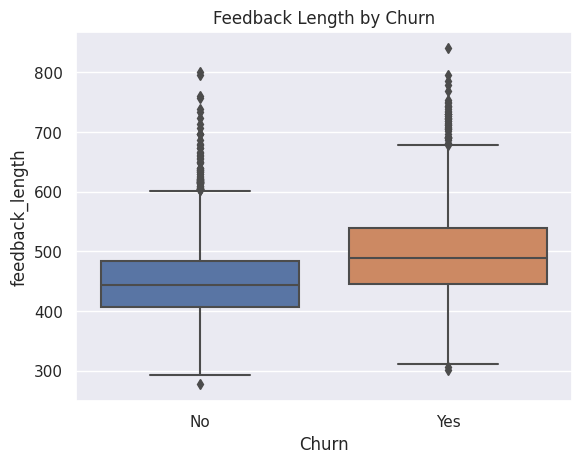

In [17]:
# Distribution of feedback lengths by churn
sns.boxplot(data=df, x='Churn', y='feedback_length')
plt.title('Feedback Length by Churn')
plt.show()

>Churned customers leave longer textual feedback on average than those who stay. <br>
This may indicate stronger emotional responses or more detailed complaints among those who leave. <br>
Feedback length can be used as a proxy for engagement or dissatisfaction in modeling. <br>

In [18]:
df['CustomerFeedback'].sample(5).tolist()

['I have been with this DSL service provider for 6 years now and I am extremely satisfied with the service. The monthly charges are reasonable at $84.2 and I appreciate the convenience of automatic bank transfers for payment. The internet service has been reliable and consistent throughout my tenure, with no issues of churn. I highly recommend this provider to others looking for a dependable internet service.',
 'I recently decided to cancel my service with this provider after being with them for 18 months. While I initially signed a one-year contract, I found that the monthly charges of $82.0 for DSL internet were too high for the quality of service I was receiving. The automatic credit card payments were convenient, but ultimately I was not satisfied with the reliability and speed of the internet service. I have since switched to a different provider that offers better value for the price.',
 'I have been a customer with this company for 10 months now and I am very satisfied with the

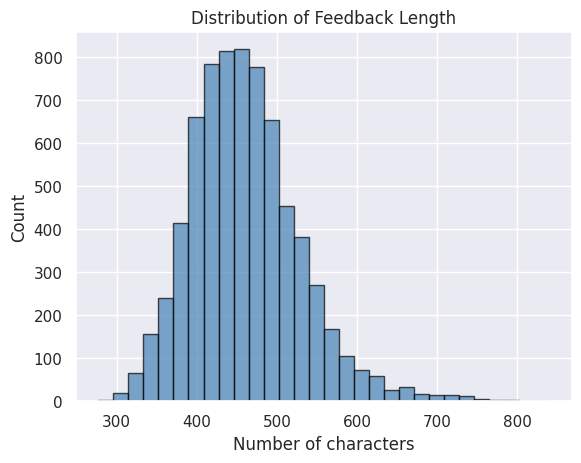

In [19]:
#feedback lenght
plt.hist(df['feedback_length'],bins=30, alpha=0.7, label='Churn = No', color='steelblue', edgecolor='black')
plt.title("Distribution of Feedback Length")
plt.xlabel("Number of characters")
plt.ylabel("Count")
plt.show()

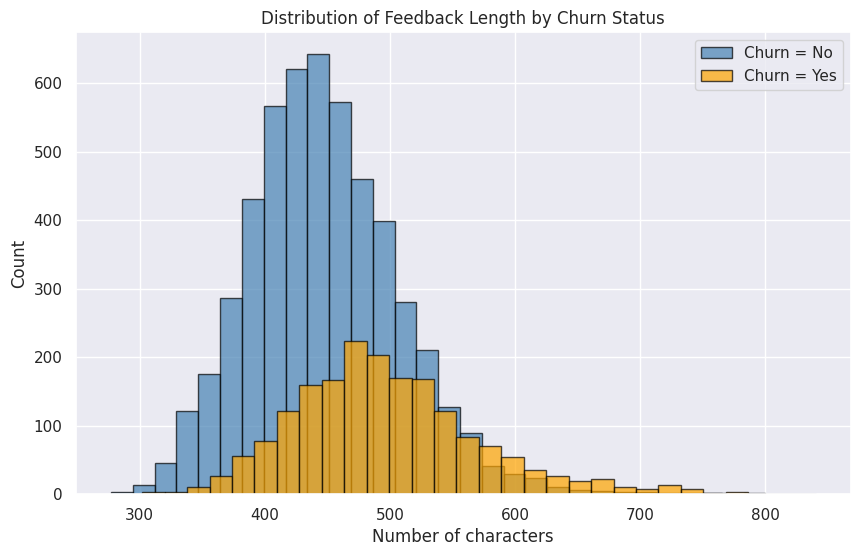

In [20]:
# Data separation
feedback_yes = df[df['Churn'] == 'Yes']['feedback_length']
feedback_no = df[df['Churn'] == 'No']['feedback_length']

# Histogram with two groups
plt.figure(figsize=(10, 6))
plt.hist(feedback_no, bins=30, alpha=0.7, label='Churn = No', color='steelblue', edgecolor='black')
plt.hist(feedback_yes, bins=30, alpha=0.7, label='Churn = Yes', color='orange', edgecolor='black')

plt.title("Distribution of Feedback Length by Churn Status")
plt.xlabel("Number of characters")
plt.ylabel("Count")
plt.legend()
plt.show()


>The histogram reveals that churned customers (orange) tend to leave longer feedback on average compared to those who stayed (blue). <br>
Both groups exhibit a similar peak (around 400–450 characters), but churned customers show a slightly longer right tail.<br>
This supports the idea that those who leave may articulate more detailed or emotionally charged feedback, which can be leveraged in modeling and segmentation.<br>

## 7. Simple sentiment analysis
<a id='Simplesentimentanalysis'></a>

In [21]:
from textblob import TextBlob

# -1(negative) +1 (pisitive)
df['sentiment'] = df['CustomerFeedback'].apply(lambda x: TextBlob(x).sentiment.polarity)
df[['CustomerFeedback', 'sentiment']].head()


,CustomerFeedback,sentiment
0,"I have been using the DSL internet service from this provider for the past month and so far, I am satisfied with the service. The connection has been reliable and the speed is sufficient for my needs. The monthly charges are reasonable at $29.85 and I appreciate the convenience of paying through electronic check. Overall, I have had a positive experience and would recommend this provider to others.",0.129545
1,"I have been a customer with this company for over two and a half years now and I have been very satisfied with their service. The DSL internet has been reliable and the monthly charges are reasonable at $56.95. I prefer to pay by mailing in a check and have never had any issues with my payments. Overall, I have no complaints and would recommend this company to others looking for internet service.",0.170833
2,"I recently signed up for DSL internet service with this provider two months ago on a month-to-month contract. Unfortunately, I have already decided to churn and switch to a different provider. The monthly charges of $53.85 were reasonable, but I found the internet service to be unreliable and slow. Additionally, having to mail in a check for payment was inconvenient and outdated. I would not recommend this provider to others looking for reliable and convenient internet service.",-0.228571
3,"I have been a loyal customer with this company for 45 months now and I am very satisfied with the service they provide. The monthly charges are reasonable at $42.3 and I appreciate the convenience of automatic bank transfer for payment. The DSL internet service has been reliable and meets my needs. Overall, I have had a positive experience with this company and have no plans to churn in the near future.",0.215801
4,"I recently switched to this fiber optic internet service provider two months ago on a month-to-month contract. The monthly charges of $70.7 seemed reasonable at first, but unfortunately I have experienced frequent outages and slow speeds. The payment method of electronic check has been convenient, but I am disappointed with the overall service. I have decided to churn and look for a more reliable internet provider.",0.030000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


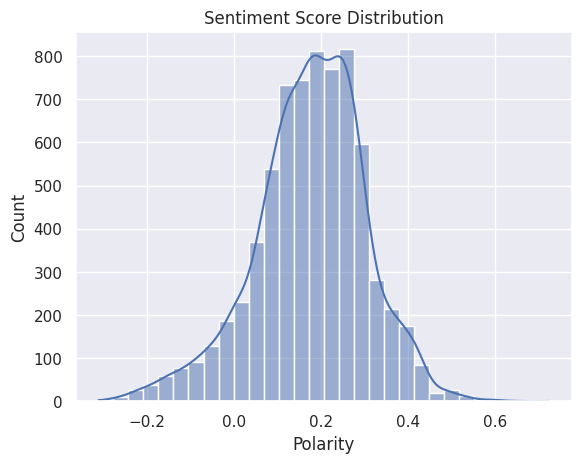

In [22]:
sns.histplot(df['sentiment'], bins=30, kde=True)
plt.title("Sentiment Score Distribution")
plt.xlabel("Polarity")
plt.show()

>The distribution of sentiment scores is centered around neutral to slightly negative polarity, suggesting that customer feedback tends to be more factual or complaint-driven. <br>
Few customers express strongly positive sentiments — likely because feedback is more common when issues arise.<br>
This supports the idea that sentiment analysis could be predictive of churn and useful for segmenting customers by emotional tone.<br>


## 8. Summary
<a id='Summary'></a>

>Key Findings:
The dataset includes 7,043 customer records, each with structured attributes and synthetic textual feedback. <br>
Churn rate is ~26%, with clear class imbalance typical in real-world scenarios.<br>
Customers on month-to-month contracts show significantly higher churn, while 1–2 year contracts improve retention.<br>
Higher monthly charges and fiber optic internet are positively associated with churn.<br>
Churned customers write longer and more expressive feedback, often highlighting dissatisfaction.<br>
Sentiment analysis shows a skew toward neutral to negative polarity, especially among churned users.<br>
Feedback length and sentiment scores exhibit statistically significant correlations with churn status.<br>

<br>

>Implications for Modeling:<br>
Textual feedback provides rich behavioral signals and can be used in:<br>
NLP-based churn classification<br>
Sentiment-aware feature engineering<br>
Hybrid models with fallback logic for missing or noisy text<br>
This analysis validates the potential of combining structured data and text in real-life churn prediction systems.<br>


## 📁 Notebook Series Overview: **Telco Churn & GPT Feedback**
<a id="notebook-series-overview-telco-churn--gpt-feedback"></a>

This is part of a multi-notebook series focused on **realistic churn prediction** using structured data and GPT-generated customer feedback.  
We simulate real-world challenges such as missing text, noisy input, and model fallback logic — building toward a robust, production-style solution.

---

###  1. Exploring Customer Churn & GPT-generated Feedback

> Exploratory analysis of the churn dataset, with focus on customer segments, behavior patterns, and text feedback characteristics.  
> Text insights powered by GPT-generated responses.

---

###  2. Feedback Noise Simulation & Fallback Testing

> We simulate feedback imperfections (irrelevant, incomplete, or missing entries) and measure how models perform under noise.  
> Introduces the concept of fallback systems for low-signal situations.

---

### 3. Fallback Model – Logistic vs XGB vs RF vs NN

> We train and compare multiple classifiers on **structured-only data** (no feedback):  
> Logistic Regression, Random Forest, XGBoost, and Neural Net.  
> Best fallback model is selected based on ROC AUC and recall.

---

###  4. Model with Feedback – Logistic vs XGB vs NN

> We focus on customers who left written feedback.  
> Structured data is combined with TF-IDF vectors to train a stronger “teacher” model.  
> Logistic Regression emerges as the most interpretable and best-performing solution.

---

### 5. Prediction using Synthetic Feedback Knowledge

> Even when customers don’t leave feedback, we simulate its predictive signal using the trained teacher model.  
> We generate a `synthetic_text_score` and evaluate whether it helps fallback performance.

---


---
**Author:** Beata Faron  
[LinkedIn](https://www.linkedin.com/in/beata-faron-24764832/) • [Kaggle](https://www.kaggle.com/beatafaron)

*Data Scientist with a background in business, design, and machine learning. Focused on time series forecasting and real-world applications.*
